# Задача 5 (бонусная): экспериментальное исследование алгоритмов для регулярных запросов

## Подготовка окружения

Для исполнения кода, приведённого в данном исследовании, необходима система с ядром Linux, подготовленная при помощи выполнения команд, приведённых далее.

In [ ]:
# @formatter:off
!pip install -r ../requirements.txt
!pip install pycubool matplotlib
# @formatter:on

## Введение

В данной работе рассматривается задача достижимости в графе с регулярными ограничениями: исследуется производительность её решений с использованием линейной алгебры при помощи библиотек языка Python, осуществляющих матричные операции на CPU и на GPU при помощи CUDA.

### О задаче достижимости

Пусть дан конечный ориентированный помеченный граф $G = (V, E, L)$, в котором каждому пути $\pi \in E^*$, состоящему из рёбер с метками $l_1, ..., l_n \in L$, сопоставляется слово по правилу $\omega(\pi) = l_1 * ... * l_n$, где $*$ --- конкатенация.

Пусть также дано регулярное выражение $R$ для языка над алфавитом $L$.

В данных условиях будем рассматривать три варианта постановки задачи о достижимости в графе $G$ с регулярными ограничениями, заданными $R$.

#### Постановка 1. Достижимость между всеми парами вершин.

Данная постановка задачи является наиболее общей. Требуется найти такие пары вершин $G$, что между ними существует путь, которому сопоставляется слово из языка, задаваемого $R$. То есть задача заключается в нахождении множества $\{(v_i, v_j) \in V^2: \exists \pi \in E^*: start(\pi) = v_i, final(\pi) = v_j, \omega(\pi) \in language(R)\}$.

#### Постановка 2. Достижимость для всего множества заданных вершин.

В данной постановке задачи из множества $V$ всех вершин графа дополнительно выделяются подмножества стартовых и финальных: $V_S \subseteq V$ и $V_F \subseteq V$ соответственно. Задача состоит в нахождении всех таких финальных вершин, что до них существуют пути из стартовых, которым сопоставляются слова из языка, задаваемого $R$. То есть задача заключается в нахождении множества $\{v_i \in V_F: \exists \pi \in E^*: start(\pi) \in V_S, final(\pi) = v_j, \omega(\pi) \in language(R)\}$.

#### Постановка 3. Достижимость для каждой вершины из заданного множества стартовых вершин.

Данная постановка задачи является комбинацией предыдущих двух. Здесь также выделяются множества стартовых и финальных вершин $V_S$ и $V_F$, в которых найденные пути должны соответственно начинаться и оканчиваться. Однако, аналогично постановке 1, здесь требуется найти множество пар вершин-начал и вершин-концов данных путей. То есть задача заключается в нахождении множества $\{(v_i, v_j) \in V_S \times V_F: \exists \pi \in E^*: start(\pi) = v_i, final(\pi) = v_j, \omega(\pi) \in language(R)\}$.

### Исследуемые решения

В данной работе для решения поставленных выше задач используются методы, кратко описываемые следующим образом:

1. **Достижимость между всеми парами вершин**. Через тензорное произведение строится пересечение конечных автоматов, соответствующих графу и регулярному выражению, для которого затем считается транзитивное замыкание через матричное возведение в степень.
2. **Достижимость для всего множества заданных вершин**. Алгоритм решения основывается на синхронном обходе в ширину конечных автоматов, соответствующих регулярному выражению и графу. Обход проводится через умножение его фронта, представленного как матрица, условно разделенная на соответствующие две части, на матрицу смежности, построенную как прямая сумма матриц смежности обоих автоматов. Матрица фронта в левой части содержит единичную матрицу, а в правой --- строки-фронты-обхода, возможные для соответствующей вершины в левой части. После каждого умножения матрица фронта трансформируется для поддержки данного инварианта.
3. **Достижимость для каждой вершины из заданного множества стартовых вершин**. Принцип решения схож с предыдущим пунктом, однако фронт разделяется для каждой стартовой вершины и представляется как единая матрица, что позволяет хранить информацию о стартовой вершине для каждой достигнутой финальной.

На практике матрицы смежности, используемые в представленных алгоритмах, являются сильно разреженными, поэтому при реализации данных алгоритмов становится выгодно представлять такие матрицы специальным образом, избегая хранения "пустых" ячеек.

В данной работе каждый из описанных алгоритмов был реализован при помощи двух библиотек языка Python, содержащих разреженные матриц:

1. [**scipy.sparse**](https://docs.scipy.org/doc/scipy/reference/sparse.html) --- модуль SciPy, предоставляющий несколько видов двухмерных разреженных массивов и проводящий все операции с ними исключительно при помощи CPU.
2. [**pycubool**](https://github.com/JetBrains-Research/cuBool) --- Python-обертка для C-библиотеки cuBool, позволяющей проводить операции линейной алгебры над разреженными матрицами на GPU при помощи технологии CUDA.

Реализации с использованием обеих библиотек максимально идентичны, на сколько это позволяют интерфейсы представленных библиотек.

#### Реализация на scipy.sparse

Реализация алгоритмов, основанная на `scipy.sparse`, расположена в модуле [`project.rpq`](../project/rpq.py) данного репозитория.

In [132]:
from project.rpq import BfsMode
from project.rpq import rpq_by_bfs
from project.rpq import rpq_by_tensor

#### Реализация на pycubool

Реализация алгоритмов, основанная на `pycubool`, представлена ниже.

In [133]:
from itertools import product
from typing import Any
from typing import NamedTuple

import pycubool as cb
from pyformlang.finite_automaton import EpsilonNFA


class BoolDecompositionCuda:
    class StateInfo(NamedTuple):
        data: Any
        is_start: bool
        is_final: bool

    def __init__(
        self,
        states: list[StateInfo] | None = None,
        adjs: dict[Any, cb.Matrix] | None = None,
    ):
        self.states: list[BoolDecompositionCuda.StateInfo] = (
            states if states is not None else []
        )
        self.adjs: dict[Any, cb.Matrix] = adjs if adjs is not None else {}

    @classmethod
    def from_nfa(
        cls, nfa: EpsilonNFA, sort_states: bool = False
    ) -> "BoolDecompositionCuda":
        # Construct states, removing duplicates
        states = list(
            set(
                cls.StateInfo(
                    data=st.value,
                    is_start=st in nfa.start_states,
                    is_final=st in nfa.final_states,
                )
                for st in nfa.states
            )
        )
        if sort_states:
            states = sorted(states, key=lambda st: st.data)

        # Construct adjacency matrices
        adjs = {}
        transitions = nfa.to_dict()
        n = len(states)
        for n_from in transitions:
            for symbol, ns_to in transitions[n_from].items():
                adj = adjs.setdefault(symbol.value, cb.Matrix.empty((n, n)))
                beg_index = next(i for i, s in enumerate(states) if s.data == n_from)
                for n_to in ns_to if isinstance(ns_to, set) else {ns_to}:
                    end_index = next(i for i, s in enumerate(states) if s.data == n_to)
                    adj[beg_index, end_index] = True

        return cls(states, adjs)

    def intersect(self, other: "BoolDecompositionCuda") -> "BoolDecompositionCuda":
        # Set of states of the intersection is the product of the given sets of states
        # State is "start" if both of its element states are "start"
        # State is "final" if both of its element states are "final"
        states = [
            self.StateInfo(
                data=(st1.data, st2.data),
                is_start=st1.is_start and st2.is_start,
                is_final=st1.is_final and st2.is_final,
            )
            for st1, st2 in product(self.states, other.states)
        ]

        # Set of symbols of the intersection is the union of the given sets of symbols
        # Adjacency matrix for a symbol is a kronecker product of the given matrices of
        # this symbol
        adjs = {}
        n = len(states)
        for symbol in set(self.adjs.keys()).union(set(other.adjs.keys())):
            if symbol in self.adjs and symbol in other.adjs:
                adjs[symbol] = self.adjs[symbol].kronecker(other.adjs[symbol])
            else:
                adjs[symbol] = cb.Matrix.empty((n, n))

        return BoolDecompositionCuda(states, adjs)

    def transitive_closure_any_symbol(self) -> tuple[list[int], list[int]]:
        # Gather all matrices to get all existing paths
        n = len(self.states)
        adj_all = cb.Matrix.empty((n, n))
        for adj in self.adjs.values():
            adj_all = adj_all.ewiseadd(adj)

        # Transitive closure by repeated-squaring-like approach
        while True:
            # nvals gives the number of paths
            prev_path_num = adj_all.nvals
            # Multiplication gives new paths, while sum retains the old ones
            adj_all.mxm(adj_all, out=adj_all, accumulate=True)
            # If no new paths appear, all paths have been discovered
            if prev_path_num == adj_all.nvals:
                break

        # Convert to a more user-friendly representation
        return adj_all.to_lists()

    def _direct_sum(self, other: "BoolDecompositionCuda") -> "BoolDecompositionCuda":
        states = self.states + other.states

        adjs = {}
        for symbol in set(self.adjs.keys()).intersection(set(other.adjs.keys())):
            dsum = cb.Matrix.empty((len(states), len(states)))
            for i, j in self.adjs[symbol]:
                dsum[i, j] = True
            for i, j in other.adjs[symbol]:
                dsum[len(self.states) + i, len(self.states) + j] = True
            adjs[symbol] = dsum

        return BoolDecompositionCuda(states, adjs)

    def constrained_bfs(
        self, constraint: "BoolDecompositionCuda", separated: bool = False
    ) -> set[int] | set[tuple[int, int]]:
        # Save states number because will use them heavily for matrix construction
        n = len(constraint.states)
        m = len(self.states)

        direct_sum = constraint._direct_sum(self)

        # Create initial front from starts of constraint (left) and self (right)
        start_states_indices = [i for i, st in enumerate(self.states) if st.is_start]
        init_front = (
            _init_bfs_front(self.states, constraint.states)
            if not separated
            else _init_separated_bfs_front(
                self.states, constraint.states, start_states_indices
            )
        )

        # Create visited, fill with zeroes instead of init_front to get rid of initial
        # positions in the result
        visited = cb.Matrix.empty(init_front.shape)

        # Perform matrix-multiplication-based-BFS until visited stops changing
        while True:
            old_visited_nvals = visited.nvals

            # Perform a BFS step for each matrix in direct sum
            for _, adj in direct_sum.adjs.items():
                # Compute new front for the symbol
                front_part = (
                    visited.mxm(adj) if init_front is None else init_front.mxm(adj)
                )
                # Transform the resulting front so that:
                # 1. It only contains rows with non-zeros in both parts.
                # 2. Its left part contains non-zeroes only on its main diagonal.
                visited = visited.ewiseadd(_transform_front_part(front_part, n))

            # Can use visited instead now
            init_front = None

            # If no new non-zero elements have appeared, we've visited all we can
            if visited.nvals == old_visited_nvals:
                break

        # If visited a final self-state in final constraint-state, we found a result
        results = set()
        for i, j in visited.to_list():
            # Check that the element is from the self part (which is the main BFS part)
            # and the final state requirements are satisfied
            if j >= n and constraint.states[i % n].is_final:  # % is for separated BFS
                self_st_index = j - n
                if self.states[self_st_index].is_final:
                    results.add(
                        self_st_index
                        if not separated
                        else (start_states_indices[i // n], self_st_index)
                    )
        return results


def _init_bfs_front(
    self_states: list[BoolDecompositionCuda.StateInfo],
    constr_states: list[BoolDecompositionCuda.StateInfo],
    self_start_indices: list[int] | None = None,
) -> cb.Matrix:
    front = cb.Matrix.empty((len(constr_states), len(constr_states) + len(self_states)))

    if self_start_indices is None:
        self_start_indices = [j for j, st in enumerate(self_states) if st.is_start]

    for i, st in enumerate(constr_states):
        if st.is_start:
            front[i, i] = True  # Mark diagonal element as start
            for j in self_start_indices:
                front[i, len(constr_states) + j] = True  # Fill start row

    return front


def _init_separated_bfs_front(
    self_states: list[BoolDecompositionCuda.StateInfo],
    constr_states: list[BoolDecompositionCuda.StateInfo],
    start_states_indices: list[int],
) -> cb.Matrix:
    fronts = [
        _init_bfs_front(
            self_states,
            constr_states,
            self_start_indices=[st_i],
        )
        for st_i in start_states_indices
    ]

    if len(fronts) == 0:
        return cb.Matrix.empty(
            (len(constr_states), len(constr_states) + len(self_states))
        )

    # Build the united front as a vertical stack of the separated fronts
    result = cb.Matrix.empty(
        (len(fronts) * len(constr_states), len(constr_states) + len(self_states))
    )
    vstack_helper = cb.Matrix.empty((len(fronts), 1))
    for i, front in enumerate(fronts):
        vstack_helper.build(rows={i}, cols={0})
        result = result.ewiseadd(vstack_helper.kronecker(front))
    return result


def _transform_front_part(front_part: cb.Matrix, constr_states_num: int) -> cb.Matrix:
    transformed_front_part = cb.Matrix.empty(front_part.shape)
    # Perform the transformation by rows
    for i, j in front_part.to_list():
        # If the element is from the constraint part
        if j < constr_states_num:
            non_zero_row_right = front_part[i: i + 1, constr_states_num:]
            # If the right part contains non-zero elements
            if non_zero_row_right.nvals > 0:
                # Account for separated front
                row_shift = i // constr_states_num * constr_states_num
                # Mark the row in the left part
                transformed_front_part[row_shift + j, j] = True
                # Update right part of the row
                for _, r_j in non_zero_row_right:
                    transformed_front_part[
                        row_shift + j, constr_states_num + r_j
                    ] = True
    return transformed_front_part

In [134]:
import networkx as nx
import pyformlang.regular_expression as re
from typing import TypeVar

from project.automata_utils import graph_to_nfa
from project.automata_utils import regex_to_min_dfa

_NodeType = TypeVar("_NodeType")


def rpq_by_tensor_cuda(
    graph: nx.Graph,
    query: str | re.Regex,
    starts: set[_NodeType] | None = None,
    finals: set[_NodeType] | None = None,
) -> set[tuple[_NodeType, _NodeType]]:
    # Create boolean decompositions for the graph and the query
    graph_decomp = BoolDecompositionCuda.from_nfa(graph_to_nfa(graph, starts, finals))
    query_decomp = BoolDecompositionCuda.from_nfa(regex_to_min_dfa(query))

    # Intersection of decompositions gives intersection of languages
    intersection = graph_decomp.intersect(query_decomp)
    # Transitive closure helps determine reachability
    transitive_closure_indices = intersection.transitive_closure_any_symbol()

    # Two nodes satisfy the query if one is the beginning of a path (i.e. a word) and
    # the other is its end
    results = set()
    for n_from_i, n_to_i in zip(*transitive_closure_indices):
        n_from = intersection.states[n_from_i]
        n_to = intersection.states[n_to_i]
        if n_from.is_start and n_to.is_final:
            beg_graph_node = n_from.data[0]
            end_graph_node = n_to.data[0]
            results.add((beg_graph_node, end_graph_node))
    return results


def rpq_by_bfs_cuda(
    graph: nx.Graph,
    query: str | re.Regex,
    starts: set[_NodeType] | None = None,
    finals: set[_NodeType] | None = None,
    mode: BfsMode = BfsMode.FIND_COMMON_REACHABLE_SET,
) -> set[_NodeType] | set[tuple[_NodeType, _NodeType]]:
    graph_decomp = BoolDecompositionCuda.from_nfa(graph_to_nfa(graph, starts, finals))
    query_decomp = BoolDecompositionCuda.from_nfa(regex_to_min_dfa(query))

    result_indices = graph_decomp.constrained_bfs(
        query_decomp, separated=mode == BfsMode.FIND_REACHABLE_FOR_EACH_START
    )

    match mode:
        case BfsMode.FIND_COMMON_REACHABLE_SET:
            return {graph_decomp.states[i].data for i in result_indices}
        case BfsMode.FIND_REACHABLE_FOR_EACH_START:
            return {
                (graph_decomp.states[i].data, graph_decomp.states[j].data)
                for i, j in result_indices
            }

## Цель работы

Целью данной работы является анализ производительности представленных решений задачи достижимости в графе с регулярными ограничениями в трёх её постановках, описанных выше. А именно, целью является нахождение ответов на следующие три вопроса:

1. При каких условиях использование `pycubool` даёт выигрыш в производительности по сравнению с `scipy.sparse`? Для каждой из трёх постановок задачи.
2. При использовании `pycubool`, для каких размеров стартового множества выгоднее решать задачу для всех пар и выбирать нужные?
3. При использовании `pycubool`, насколько решение задачи во второй её постановке быстрее решения в третьей при одинаковых начальных условиях?

## Условия эксперимента

В данной секции описывается, каким образом проводился эксперимент, соответствующий цели данной работы.

### Характеристики оборудование

Оборудование, на котором проводились описанные далее замеры, обладает следующими характеристиками:

In [202]:
# @formatter:off

! printf '========== OS  ==========\n'
! hostnamectl | grep -E 'Operating System|Kernel'

! printf '\n========== CPU ==========\n'
! lscpu | grep -E 'Architecture|Model name|Thread\(s\)|Core\(s\)|Socket\(s\)|MHz|cache'

! printf '\n========== GPU ==========\n'
! nvidia-smi -L
! nvidia-smi | grep CUDA

! printf '\n========== RAM ==========\n'
! free -m

# @formatter:on

========== OS  ==========
Operating System: Ubuntu 22.04.1 LTS
          Kernel: Linux 5.15.0-50-generic

========== CPU ==========
Architecture:                    x86_64
Model name:                      AMD Ryzen 5 5600X 6-Core Processor
Thread(s) per core:              2
Core(s) per socket:              6
Socket(s):                       1
CPU max MHz:                     4650.2920
CPU min MHz:                     2200.0000
L1d cache:                       192 KiB (6 instances)
L1i cache:                       192 KiB (6 instances)
L2 cache:                        3 MiB (6 instances)
L3 cache:                        32 MiB (1 instance)

========== GPU ==========
GPU 0: NVIDIA GeForce RTX 2060 (UUID: GPU-8294f82e-bdf0-92ae-58e4-939c50d2a707)
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |

========== RAM ==========
               total        used        free      shared  buff/cache   available
Mem:           15920       11155        1351          59  

### Описание использованного набора данных

Для проведения экспериментов необходимо выбрать графы для поиска путей в них и регулярные выражения для задания ограничений на поиск, а также определить способ выбора множеств стартовых и финальных вершин.

#### Выбор графов

Эксперимент проводился на десяти графах из [датасета CFPQ_Data](https://jetbrains-research.github.io/CFPQ_Data/dataset/index.html): `skos`, `travel`, `atom`, `bzip`, `pr`, `funding`, `ls`, `pizza`, `gzip` и `pathways`.

Графы из данного датасета, обладающие большим числом вершин или рёбер, протестировать аналогичным образом на оборудовании с представленными характеристиками не представлялось возможным, так как запуск алгоритмов на них занимал чрезмерно большое количество времени. К примеру, граф `enzyme`, следующий по размеру в датасете после `pathways`, каждый алгоритм на одних входных данных обрабатывал около восьми минут.

Выбранные же графы были взяты как наиболее репрезентативные в датасете по числу рёбер и вершин среди тех, что удовлетворяют указанному ограничению.

In [ ]:
from project.graph_utils import load_graph_from_cfpq_data

GRAPHS: list[nx.Graph] = []


def init_graphs():
    for name in [
        "skos",
        "travel",
        "atom",
        "bzip",
        "pr",
        "funding",
        "ls",
        "pizza",
        "gzip",
        "pathways",
    ]:
        graph = load_graph_from_cfpq_data(name)
        graph.name = name
        GRAPHS.append(graph)


init_graphs()

Ниже приведена информация о выбранных графах.

In [137]:
import pandas as pd
from collections import Counter
from project.graph_utils import get_graph_info


def get_most_common(source: list[str], n: int) -> list[tuple[str, int]]:
    return sorted(Counter(source).most_common(n), key=lambda x: (x[1], x[0]), reverse=True)


def graph_stats() -> pd.DataFrame:
    stats = []

    for graph in GRAPHS:
        info = get_graph_info(graph)
        stats.append([
            graph.name,
            info.nodes_num,
            info.edges_num,
            info.edges_num / info.nodes_num,
            get_most_common(info.labels, 4),
        ])

    return pd.DataFrame(
        sorted(stats, key=lambda st: st[2]),
        columns=["Name", "Nodes", "Edges", "Edges per node", "Labels (most common -> least common)"],
    )


pd.set_option("display.max_colwidth", None)
graph_stats()

,Name,Nodes,Edges,Edges per node,Labels (most common -> least common)
0,skos,144,252,1.750000,"[(type, 70), (label, 32), (isDefinedBy, 32), (definition, 32)]"
1,travel,131,277,2.114504,"[(type, 90), (subClassOf, 30), (rest, 24), (first, 24)]"
2,atom,291,425,1.460481,"[(type, 138), (label, 129), (subClassOf, 122), (comment, 11)]"
3,bzip,632,556,0.879747,"[(d, 297), (a, 259)]"
4,pr,815,692,0.849080,"[(d, 359), (a, 333)]"
5,funding,778,1086,1.395887,"[(type, 304), (label, 231), (comment, 229), (subClassOf, 90)]"
6,ls,1687,1453,0.861292,"[(d, 750), (a, 703)]"
7,pizza,671,1980,2.950820,"[(disjointWith, 398), (type, 365), (subClassOf, 259), (onProperty, 188)]"
8,gzip,2687,2293,0.853368,"[(d, 1218), (a, 1075)]"
9,pathways,6238,12363,1.981885,"[(type, 3118), (subClassOf, 3117), (label, 3117), (narrower, 3010)]"


#### Выбор регулярных выражений

Для каждого графа создавалось по четыре регулярных выражения следующих видов:

1. $R_1 = l_1 \ | \ l_2$ --- одно из наиболее простых выражений.
2. $R_2 = (l_1 \ | \ l_2) \ (l_3 \ | \ l_4)$ --- более сложное выражение.
3. $R_3 = l_1 \ l_2 \ l_3 \ l_4$ --- выражение со сравнительно большим числом состояний и малым числом переходов в конечном автомате.
4. $R_4 = (l_1 \ | \ l_2 \ | \ l_3 \ | \ l_4)^* \ l_3 \ l_4$ --- выражение со сравнительно большим числом переходов и малым числом состояний в конечном автомате.

В качестве меток $l_1$, $l_2$, $l_3$, $l_4$ выбирались четыре наиболее часто встречающиеся в конкретном графе метки в порядке убывания количества рёбер с ними (если метки появляются на равном числе рёбер, то они сортируются в обратном алфавитном порядке). Если в графе менее четырёх меток, то существующие метки брались повторно в том же порядке необходимое количество раз. То есть, если граф обладает метками `ab` и `ac` на трёх рёбрах и меткой `b` --- на одном, то для этого графа $l_1 =$`ac`, $l_2 =$`ab`, $l_3 =$`b`, $l_4 =$`ac`.

Далее представлен код для генерации описанных регулярных выражений.

In [138]:
import pyformlang.finite_automaton as fa

REGEX_LABELS_NUM = 4


def label_to_regexp(l: str) -> re.Regex:
    re0 = re.Regex("")
    re0.head = fa.Symbol(l)
    return re0


def r1(l1: str, l2: str, _l3: str, _l4: str) -> re.Regex:
    del _l3, _l4
    re1 = label_to_regexp(l1)
    re2 = label_to_regexp(l2)
    return re1.union(re2)


def r2(l1: str, l2: str, l3: str, l4: str) -> re.Regex:
    re1 = label_to_regexp(l1)
    re2 = label_to_regexp(l2)
    re12 = re1.union(re2)

    re3 = label_to_regexp(l3)
    re4 = label_to_regexp(l4)
    re34 = re3.union(re4)

    return re12.concatenate(re34)


def r3(l1: str, l2: str, l3: str, l4: str) -> re.Regex:
    re1 = label_to_regexp(l1)
    re2 = label_to_regexp(l2)
    re3 = label_to_regexp(l3)
    re4 = label_to_regexp(l4)
    return re1.concatenate(re2).concatenate(re3).concatenate(re4)


def r4(l1: str, l2: str, l3: str, l4: str) -> re.Regex:
    re1 = label_to_regexp(l1)
    re2 = label_to_regexp(l2)
    re3 = label_to_regexp(l3)
    re4 = label_to_regexp(l4)
    re1234 = re1.union(re2).union(re3).union(re4)
    re1234 = re1234.kleene_star()

    return re1234.concatenate(re3).concatenate(re4)


REGEXES = {
    "l1 | l2": r1,
    "(l1 | l2) (l3 | l4)": r2,
    "l1 l2 l3 l4": r3,
    "(l1 | l2 | l3 | l4)* l3 l4": r4
}


def create_regexes_for_graph(graph: nx.Graph) -> list[re.Regex]:
    info = get_graph_info(graph)
    labels = get_most_common(info.labels, REGEX_LABELS_NUM)
    while len(labels) < REGEX_LABELS_NUM:
        labels += labels
    labels = labels[:REGEX_LABELS_NUM]

    return [r(*labels) for r in REGEXES.values()]

Также ниже приведены характеристики данных регулярных выражений как конечных автоматов, к которым они будут сводиться в исследуемых алгоритмах.

In [139]:
def regex_stats() -> pd.DataFrame:
    stats = []

    for s, r in [(s, r("a", "b", "c", "d")) for s, r in REGEXES.items()]:
        dfa = regex_to_min_dfa(r)
        stats.append([
            s,
            len(dfa.symbols),
            len(dfa.states),
            dfa.get_number_transitions(),
            dfa.get_number_transitions() / len(dfa.states),
        ])

    return pd.DataFrame(stats, columns=["Regex", "Symbols", "States", "Transitions", "Transitions per state"])


regex_stats()

,Regex,Symbols,States,Transitions,Transitions per state
0,l1 | l2,2,2,2,1.000000
1,(l1 | l2) (l3 | l4),4,3,4,1.333333
2,l1 l2 l3 l4,4,5,4,0.800000
3,(l1 | l2 | l3 | l4)* l3 l4,4,3,12,4.000000


#### Выбор множеств стартовых и финальных вершин

Стоит отметить, что множество стартовых вершин может заметно и нетривиально повлиять на быстродействие алгоритмов, решающих задачу в постановках 2 и 3, так как если из выбранных вершин достижима лишь малая область графа, то обход завершится быстрее. Для алгоритма в постановке задачи под номером 3 число стартовых вершин также влияет на размер матрицы-фронта. Поэтому для обеспечения воспроизводимости результатов эксперимента множества стартовых вершин генерировались при помощи функции [`generate_multiple_source`](https://jetbrains-research.github.io/CFPQ_Data/reference/graphs/generated/cfpq_data.graphs.utils.multiple_source_utils.html#cfpq_data.graphs.utils.multiple_source_utils.generate_multiple_source) из библиотеки CFPQ_Data со значением параметра `seed`, равным `42`.

In [ ]:
# Seed to generate the set of start nodes
START_SET_SEED = 42

Так как для вопроса 2 из цели данной работы требуется изучить влияние размера множества стартовых вершин, то значение параметра `set_size` указанной функции генерации стартового множества определялось отдельно для конкретного замера. Для экспериментов были выбраны размеры от допустимых в наименьших графов до допустимых в наибольших.

In [140]:
# Percent of nodes to take as start in the fixed-start experiment
FIXED_START_SIZE = 50
# Sizes of start sets in varied-start experiment
VARIED_START_SIZES = [50, 100, 200, 400, 800, 1500, 3000, 6000]

Напротив, множество финальных вершин влияет на быстродействие всех трёх алгоритмов тривиально и лишь своим размером: во всех случаях на завершающем этапе достигнутые вершины проверяются на принадлежность к множеству финальных вершин, что происходит через поиск по множеству. Поэтому для простоты в качестве множества финальных вершин выбиралось всё множество вершин графа.

### Проводимые замеры

Для ответа на каждый из поставленных в цели работы вопросов нужно провести соответствующие замеры.

#### Замеры для вопроса 1 (о выгоде от использования `pycubool`)

Для выяснения того, при каких условиях использование `pycubool` даёт выигрыш в производительности против использования `scipy.sparse`, необходимо выявить основные характеристики матриц, которые влияют на скорость выполнения данными библиотеками матричных операций.

Естественно предположить, что это размер матрицы и её степень разреженности (мера того, насколько матрица заполнена пустыми элементами): чем больше размер и чем меньше разреженность, тем больше нетривиальных операций над ячейками матрицы нужно провести для получения ответа. Среди параметров графа и регулярного выражения на эти величины влияют, соответственно, число вершин (или же состояний конечного автомата, в случае регулярного выражения) и отношение числа рёбер (переходов) к числу вершин (состояний).

Таким образом, для каждого из трёх алгоритмов для реализаций на `scipy.sparse` и `pycubool` следует замерить скорость их работы на всевозможных комбинациях выбранных графов и регулярных выражений с фиксированными стартовыми множествами и проследить зависимость разницы данных скоростей от указанных параметров.

#### Замеры для вопроса 2 (о влиянии размера стартового множества на выгоду от использования решений первой и третьей постановок)

Чтобы понять, при каких размерах множества стартовых вершин, используя `pycubool`, эффективнее решать задачу в её первой постановке (то есть искать достижимые вершины среди всех пар вершин, но затем отбирать нужные), а при каких --- в третьей (то есть искать достижимые вершины лишь от стартовых вершин, но от каждой по-отдельности), требуется замерить скорость работы данных решений, реализованных на `pycubool`, на всевозможных комбинациях выбранных графов и регулярных выражений при разных размерах стартового множества вершин. В итоге требуется проследить, какая из реализаций будет показывать лучший результат в зависимости от размеров стартового множества.

#### Замеры для вопроса 3 (о сравнении быстродействия решений второй и третьей постановок)

Чтобы выяснить, насколько решение задачи на `pycubool` в её второй постановке (поиск для всего стартового множества вместе) быстрее решения в третьей (поиск для каждой стартовой вершины отдельно) при равных начальных условиях нужно замерить время их работы на одинаковых графах и регулярных запросах с равными стартовыми множествами и сравнить результаты.

#### Итог по необходимым замерам

Итого, для ответа на все три вопроса достаточно провести следующие замеры времени выполнения исследуемых реализаций:

- на всевозможных комбинациях выбранных графов и регулярных выражений с фиксированными стартовыми множествами --- для всех реализаций;
- на всевозможных комбинациях выбранных графов, регулярных выражений и размеров стартовых множеств --- для реализаций первой и третьей постановок задачи на `pycubool`.

Время работы каждого алгоритма на каждый входных данных замерялось пять раз подряд для получения среднего значения и стандартного отклонения. Замеры проводились при помощи модуля [`timeit`](https://docs.python.org/3/library/timeit.html), минимизирующего разброс их результатов.

In [203]:
import timeit
from statistics import fmean
from statistics import stdev
import signal
from typing import Callable

# Number of consecutive times each measurement is run
RUN_TIMES = 5


class RunTimeoutError(Exception):
    pass


def timeout_handler(_signum, _frame):
    print("Time out", end=" ")
    raise RunTimeoutError


def run_timed(f: Callable, run_times: int, timeout_each_s: int = 600):
    timeout_total_s = timeout_each_s * run_times

    signal.signal(signal.SIGALRM, timeout_handler)
    try:
        signal.alarm(timeout_total_s)
        times = timeit.repeat(f, repeat=run_times, number=1)
    except RunTimeoutError:
        times = [float("inf")]
    finally:
        signal.alarm(0)

    m = fmean(times)
    sd = stdev(times, m) if len(times) > 1 else 0.0
    return m, sd

Ниже представлен код для проведения описанных замеров.

In [ ]:
from cfpq_data import generate_multiple_source


def run_fixed_starts():
    results = []

    for g_i, graph in enumerate(GRAPHS, start=1):
        regexes = create_regexes_for_graph(graph)
        starts = generate_multiple_source(graph, FIXED_START_SIZE, seed=START_SET_SEED)
        print(f"########## Graph {graph.name} ({g_i} / {len(GRAPHS)}, run times = {RUN_TIMES}) ##########")

        graph_results = []
        for r_i, regex in enumerate(regexes, start=1):
            print(f"========== Regex #{r_i} ==========")

            print("by_tensor", end=" ")
            by_tensor = run_timed(
                lambda: rpq_by_tensor(graph, regex, starts=starts),
                run_times=RUN_TIMES,
            )
            print(by_tensor)

            print("by_bfs_all", end=" ")
            by_bfs_all = run_timed(
                lambda: rpq_by_bfs(graph, regex, starts=starts, mode=BfsMode.FIND_COMMON_REACHABLE_SET),
                run_times=RUN_TIMES,
            )
            print(by_bfs_all)

            print("by_bfs_each", end=" ")
            by_bfs_each = run_timed(
                lambda: rpq_by_bfs(graph, regex, starts=starts, mode=BfsMode.FIND_REACHABLE_FOR_EACH_START),
                run_times=RUN_TIMES,
            )
            print(by_bfs_each)

            print("by_tensor_cuda", end=" ")
            by_tensor_cuda = run_timed(
                lambda: rpq_by_tensor_cuda(graph, regex, starts=starts),
                run_times=RUN_TIMES,
            )
            print(by_tensor_cuda)

            print("by_bfs_all_cuda", end=" ")
            by_bfs_all_cuda = run_timed(
                lambda: rpq_by_bfs_cuda(graph, regex, starts=starts, mode=BfsMode.FIND_COMMON_REACHABLE_SET),
                run_times=RUN_TIMES,
            )
            print(by_bfs_all_cuda)

            print("by_bfs_each_cuda", end=" ")
            by_bfs_each_cuda = run_timed(
                lambda: rpq_by_bfs_cuda(graph, regex, starts=starts, mode=BfsMode.FIND_REACHABLE_FOR_EACH_START),
                run_times=RUN_TIMES,
            )
            print(by_bfs_each_cuda)

            graph_results.append(
                ((by_tensor, by_bfs_all, by_bfs_each), (by_tensor_cuda, by_bfs_all_cuda, by_bfs_each_cuda))
            )

        results.append(graph_results)

    return results


def run_varied_starts():
    results = []

    for g_i, graph in enumerate(GRAPHS, start=1):
        regexes = create_regexes_for_graph(graph)
        print(f"########## Graph {graph.name} ({g_i} / {len(GRAPHS)}, run times = {RUN_TIMES}) ##########")

        graph_results = []
        for r_i, regex in enumerate(regexes, start=1):
            print(f"========== Regex #{r_i} ==========")

            regex_results = {}
            for start_size in VARIED_START_SIZES:
                if start_size > graph.number_of_nodes():
                    continue
                starts = generate_multiple_source(graph, start_size, seed=START_SET_SEED)
                print(f"********** Start size #{start_size} **********")

                print("by_tensor_cuda", end=" ")
                by_tensor_cuda = run_timed(
                    lambda: rpq_by_tensor_cuda(graph, regex, starts=starts),
                    run_times=RUN_TIMES,
                )
                print(by_tensor_cuda)

                print("by_bfs_each_cuda", end=" ")
                by_bfs_each_cuda = run_timed(
                    lambda: rpq_by_bfs_cuda(graph, regex, starts=starts, mode=BfsMode.FIND_REACHABLE_FOR_EACH_START),
                    run_times=RUN_TIMES,
                )
                print(by_bfs_each_cuda)

                regex_results[start_size] = (by_tensor_cuda, by_bfs_each_cuda)

            graph_results.append(regex_results)

        results.append(graph_results)

    return results


fixed_starts_res = run_fixed_starts()
varied_starts_res = run_varied_starts()

## Результаты эксперимента

В данном разделе демонстрируются результаты проведённых замеров и, исходя из них, даются ответы на поставленные ранее вопросы.

In [143]:
import matplotlib.pyplot as plt
import numpy as np

ALGO_NAMES = ["Tensor multiplication", "United BFS", "Separated BFS"]

### Результаты по вопросу 1 (о выгоде от использования `pycubool`)

Как видно из графиков 1.1.1 и 1.1.2, демонстрирующих относительную разность во времени работы реализаций алгоритмов, для решений первой и второй постановок задачи (то есть для тензорного произведения и BFS для всего стартового множества без разделения) основным фактором, влияющим на относительную величину разности времени исполнения алгоритмов, реализованных на `scipy.sparse` и на `pycubool`, является размер графа.

Под размером графа здесь понимается как число рёбер, так и число вершин. Влияние первого в целом заметно на графиках: графы отсортированы по числу рёбер и по графикам сверху вниз, слева направо разрыв уменьшается. Влияние же числа вершин особенно явно заметно при сравнении графиков для графов `ls` (1687 вершин, 1453 ребра) и `pizza` (671 вершина, 1980 рёбер) --- `pizza` больше в терминах количества рёбер, однако у него наблюдается меньший разрыв между реализациями, чем у `ls`, так как `pizza` меньше в терминах количества вершин.

На всех рассмотренных графах для данных постановок `pycubool` показывает себя лучше `scipy.sparse`, однако, чем больше граф, тем меньше разрыв между реализациями. Рассматривая на данную тенденцию, можно предположить, что при дальнейшем увеличении размеров графов `scipy.sparse` может сравняться с (или даже выиграть у) `pycubool` в производительности.

Также стоит отметить, что

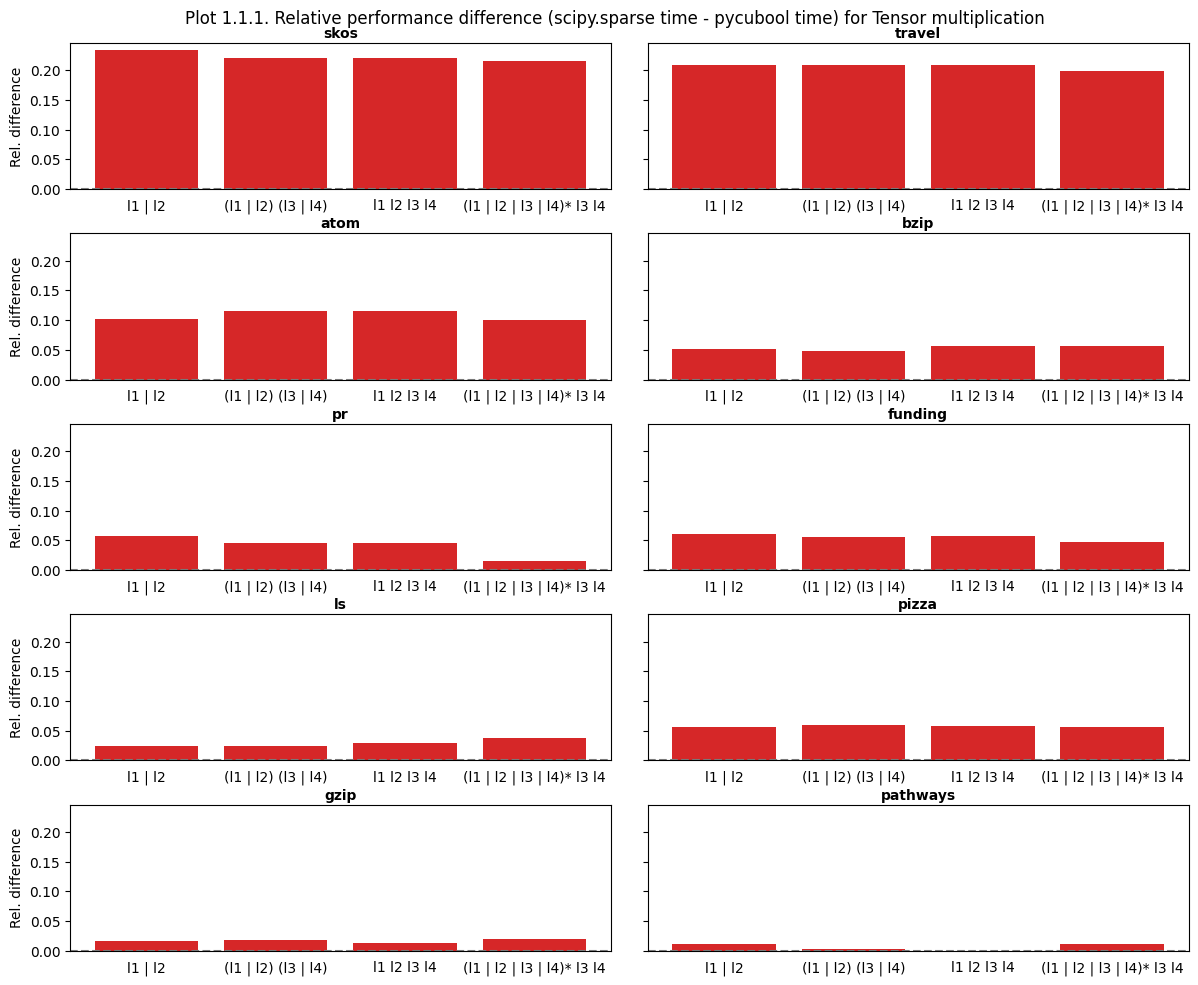

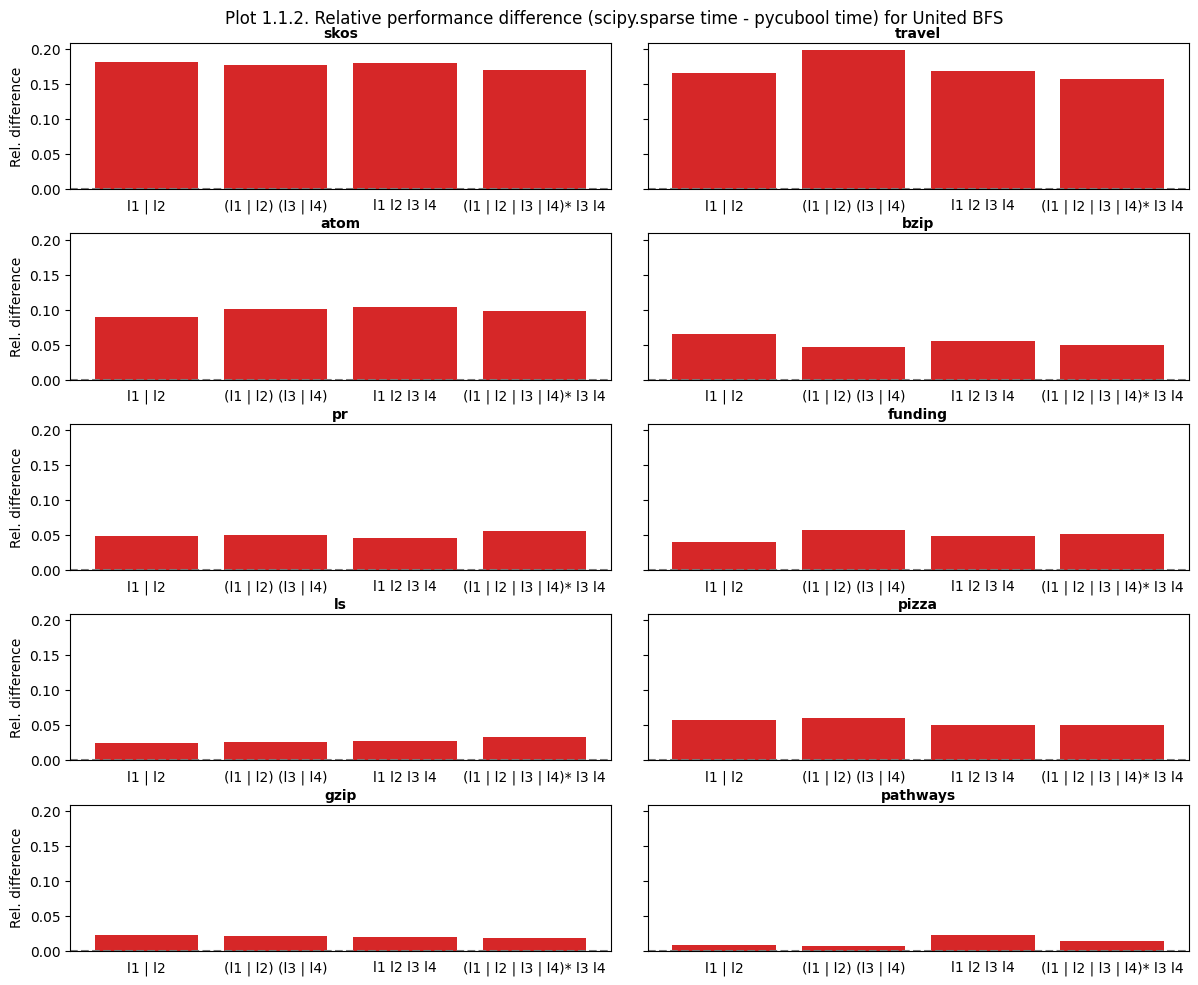

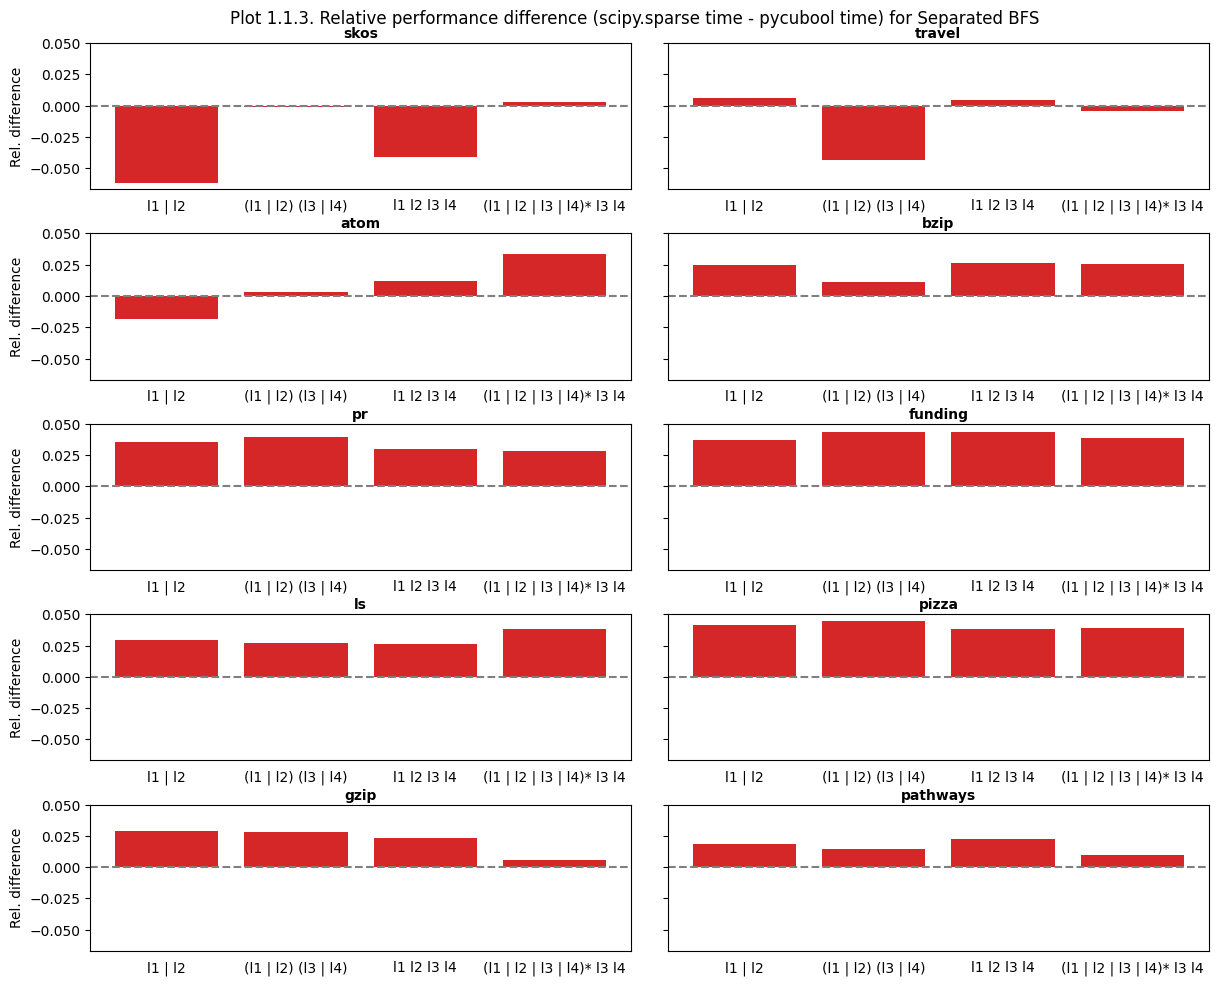

In [206]:
def show_rel_plots_1(
    res: list[list[tuple[tuple[tuple[float, float], tuple[float, float], tuple[float, float]], tuple[
        tuple[float, float], tuple[float, float], tuple[float, float]]]]]
):
    fig_size = (3 * len(REGEXES), len(GRAPHS))

    for algo_i, algo_name in enumerate(ALGO_NAMES):
        fig: plt.Figure
        fig, axs = plt.subplots(len(GRAPHS) // 2, 2, figsize=fig_size, sharey=True)

        fig.suptitle(
            f"Plot 1.1.{algo_i + 1}. Relative performance difference (scipy.sparse time - pycubool time) for {algo_name}")
        fig.tight_layout()

        ax: plt.Axes
        for g_i, ax in enumerate(axs.flat):
            graph_name = GRAPHS[g_i].name
            graph_results = res[g_i]

            ax.set_xlabel(graph_name, weight="bold")
            ax.xaxis.set_label_position("top")

            ax.tick_params(axis='x', which='both', bottom=False)
            if g_i % len(axs[0]) == 0:
                ax.set_ylabel("Rel. difference")

            ax.axhline(color="tab:grey", linestyle="--")

            scipy_means = [rs[0][algo_i][0] for rs in graph_results]
            pycubool_means = [rs[1][algo_i][0] for rs in graph_results]
            ax.bar(
                REGEXES.keys(),
                [(m1 - m2) / (m1 + m2) for m1, m2 in zip(scipy_means, pycubool_means)],
                color="tab:red",
            )

    plt.show()


show_rel_plots_1(fixed_starts_res)

Для решения третьей постановки задачи (BFS для каждой стартовой вершины отдельно) относительная разность (график 1.1.3) не имеет столь явных тенденций. Однако, исходя из абсолютного времени работы, продемонстрированного на графике 1.2.3, можно сделать вывод, что относительными разностями не в пользу `pycubool` обуславливаются погрешностью. А погрешность, в свою очередь, вероятно, вызвана малой абсолютной разностью между измеренными величинами: как видно, разность в данных случаях исчисляется сотыми долями секунды.

В целом же, для решения постановки 3 относительная разность между `pycubool` и `scipy.sparse` также снижается при росте размера графа: на меньших графах размера выгоднее использовать `pycubool`, а для графов большего можно также предположить, что `scipy.sparse` будет показывать себя примерно аналогично или лучше.

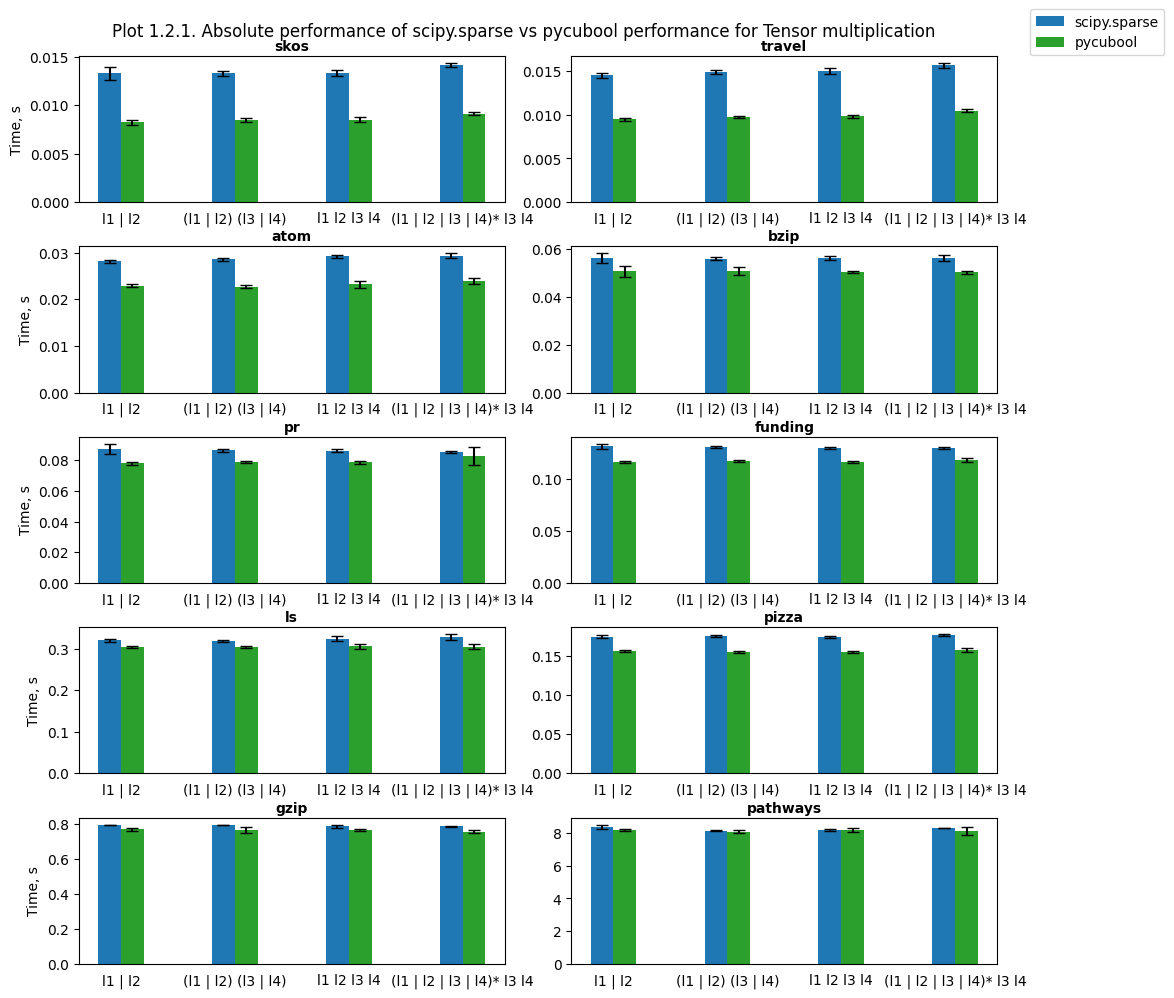

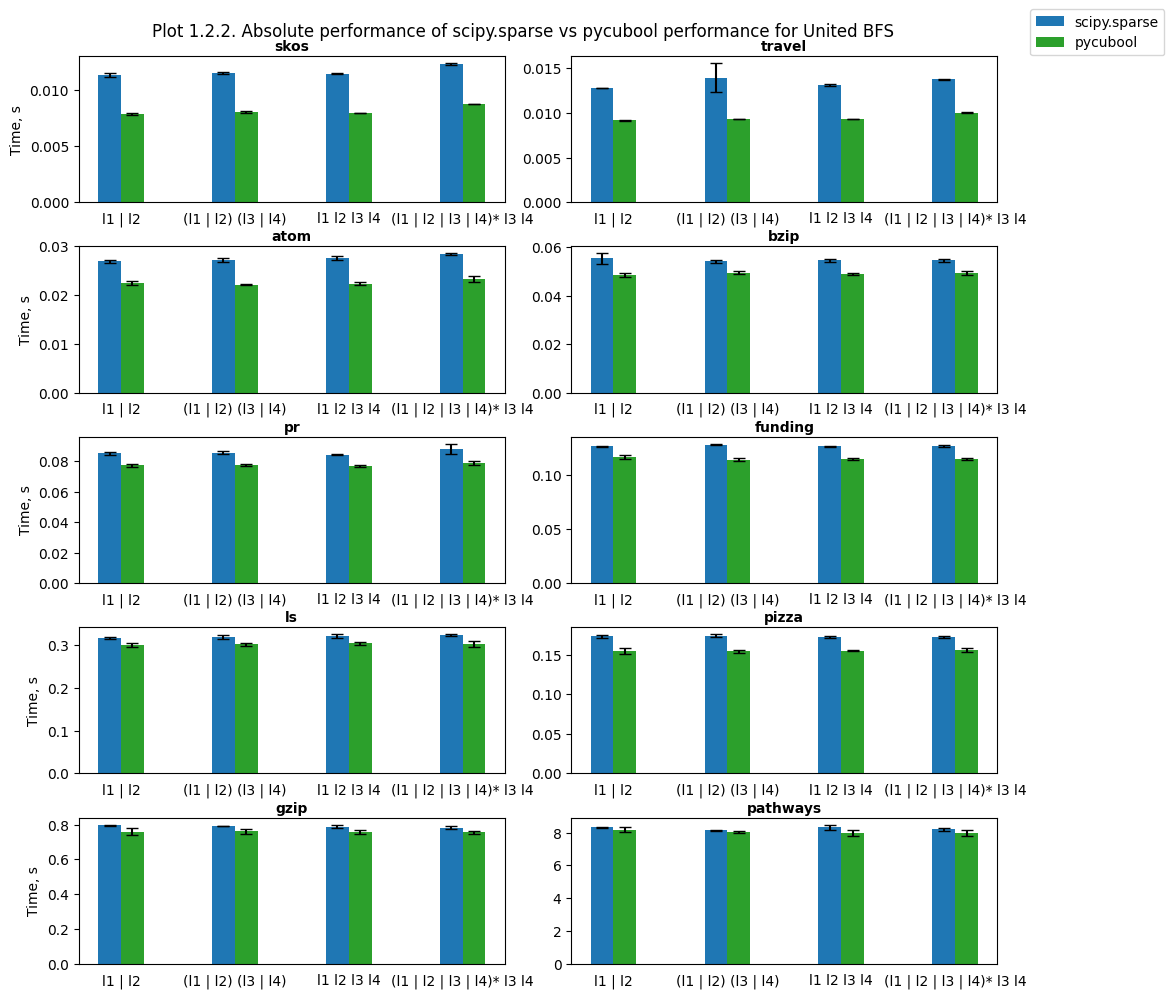

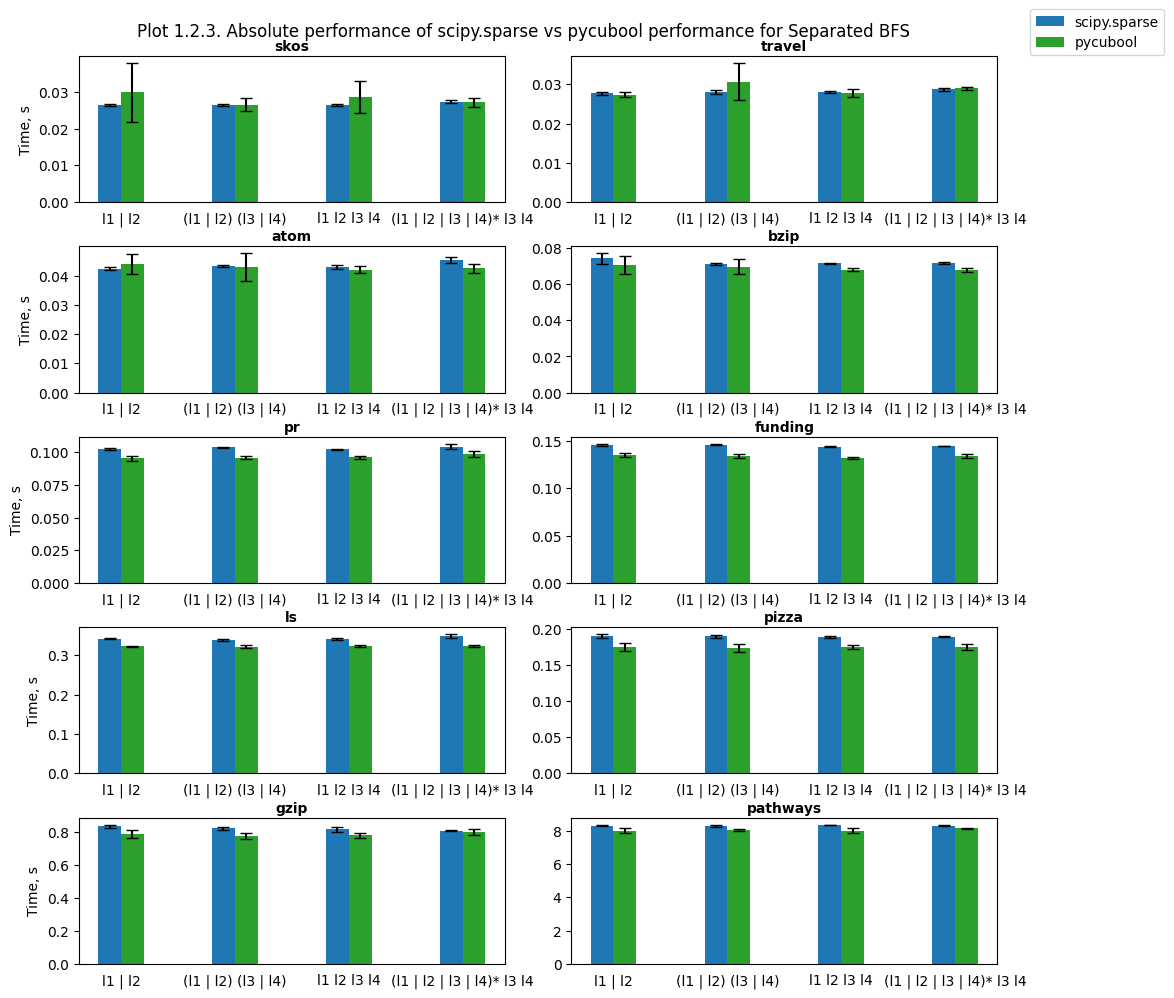

In [185]:
def show_abs_plots_1(
    res: list[list[tuple[tuple[tuple[float, float], tuple[float, float], tuple[float, float]], tuple[
        tuple[float, float], tuple[float, float], tuple[float, float]]]]]
):
    fig_size = (2.5 * len(REGEXES), len(GRAPHS))
    label_locations = np.arange(len(REGEXES))
    bar_width = 0.2
    cap_size = 4

    for algo_i, algo_name in enumerate(ALGO_NAMES):
        fig: plt.Figure
        fig, axs = plt.subplots(len(GRAPHS) // 2, 2, figsize=fig_size)

        fig.suptitle(
            f"Plot 1.2.{algo_i + 1}. Absolute performance of scipy.sparse vs pycubool performance for {algo_name}")
        fig.tight_layout()

        ax: plt.Axes
        for g_i, ax in enumerate(axs.flat):
            graph_name = GRAPHS[g_i].name
            graph_results = res[g_i]

            ax.set_xlabel(graph_name, weight="bold")
            ax.xaxis.set_label_position("top")

            ax.set_xticks(label_locations, REGEXES.keys())
            ax.tick_params(axis='x', which='both', bottom=False)
            if g_i % len(axs[0]) == 0:
                ax.set_ylabel("Time, s")

            scipy_means = [rs[0][algo_i][0] for rs in graph_results]
            scipy_stdevs = [rs[0][algo_i][1] for rs in graph_results]
            ax.bar(
                label_locations - bar_width / 2,
                scipy_means,
                bar_width,
                yerr=scipy_stdevs,
                color="tab:blue",
                label="scipy.sparse",
                capsize=cap_size,
            )

            pycubool_means = [rs[1][algo_i][0] for rs in graph_results]
            pycubool_stdevs = [rs[1][algo_i][1] for rs in graph_results]
            ax.bar(
                label_locations + bar_width / 2,
                pycubool_means,
                bar_width,
                yerr=pycubool_stdevs,
                color="tab:green",
                label="pycubool",
                capsize=cap_size,
            )

        handles, labels = axs[-1][-1].get_legend_handles_labels()
        fig.legend(handles, labels, bbox_to_anchor=(1, 1), loc="upper left")

    plt.show()


show_abs_plots_1(fixed_starts_res)

Помимо вышесказанного стоит отметить, что влияния отношения числа рёбер к числу вершин в графе, как и характеристик регулярных выражений, для решений задачи во всех трёх постановках выявлено не было.

### Результаты по вопросу 2 (о влиянии размера стартового множества на выгоду от использования решений первой и третьей постановок)

Время работы решений задачи в постановках 1 и 3, реализованных на `pycubool`, продемонстрировано на графике 2. Как можно заметить, для всех выбранных графов даже для незначительных по размеру (относительно общего числа вершин в графе) стартовых множеств эффективнее решать задачу в первой постановке (то есть использовать алгоритм, основанный на тензорном произведении) и выбирать из всех найденных пар нужные. Причем, при увеличении числа стартовых вершин разрыв во времени увеличивается, так как время, затрачиваемое на решение задачи в первой постановке остается приблизительно тем же, а в третьей --- растёт.

Однако, при увеличении размера графа разница во времени для малых размеров стартовых множеств падает, поэтому можно предположить, что для больших графов и малого числа стартовых вершин выгода от использования решения задачи в третьей постановке все же появится.

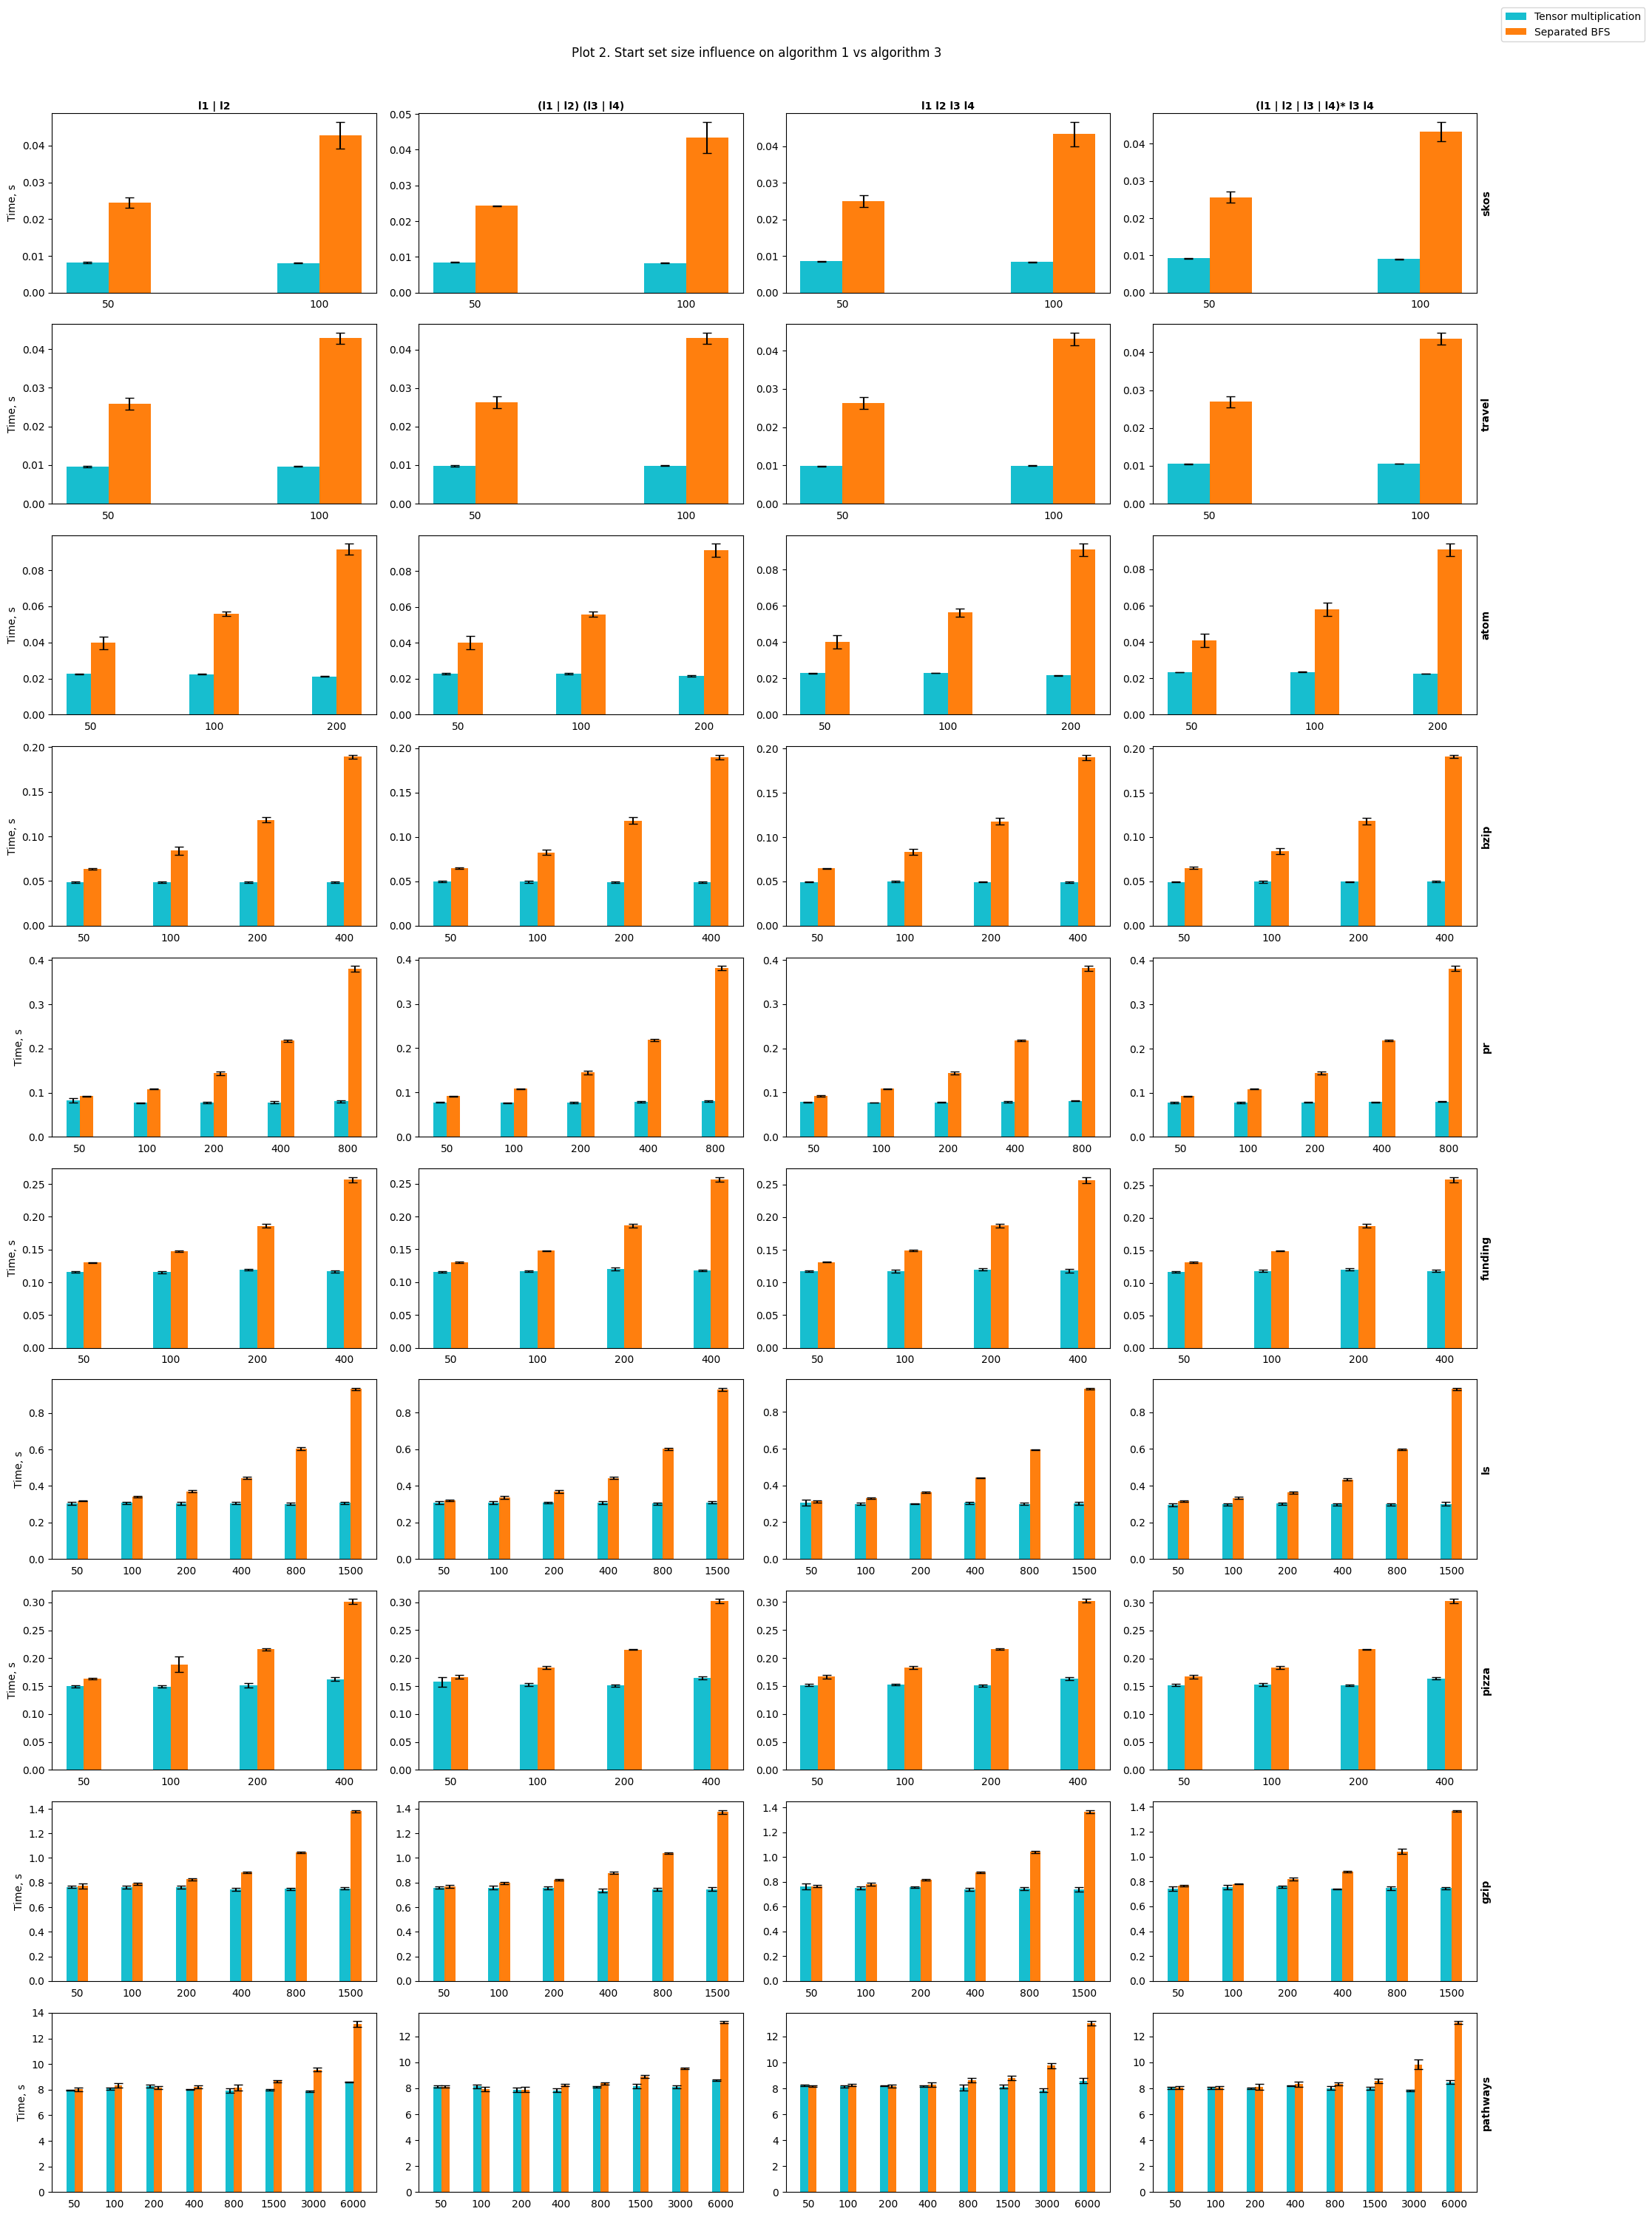

In [186]:
def show_plots_2(res: list[list[dict[int, tuple[tuple[float, float], tuple[float, float]]]]]):
    fig: plt.Figure
    fig, axs = plt.subplots(len(GRAPHS), len(REGEXES), figsize=(5 * len(REGEXES), 3 * len(GRAPHS)))

    fig.suptitle("Plot 2. Start set size influence on algorithm 1 vs algorithm 3")
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)  # Fixes plots overlapping the title

    bar_width = 0.2
    cap_size = 4

    for g_i, axs_row in enumerate(axs):
        graph_name = GRAPHS[g_i].name
        graph_results = res[g_i]

        ax: plt.Axes
        for r_i, ax in enumerate(axs_row):
            regex_name = list(REGEXES.keys())[r_i]
            regex_results = graph_results[r_i]

            if g_i == 0:
                ax.set_xlabel(regex_name, weight="bold")
                ax.xaxis.set_label_position("top")

            if r_i == 0:
                ax.set_ylabel("Time, s")

            if r_i == len(REGEXES) - 1:
                ax.set_ylabel(graph_name, weight="bold")
                ax.yaxis.set_label_position("right")

            label_locations = np.arange(len(regex_results))
            ax.set_xticks(label_locations, regex_results.keys())

            algo1_results = [rs[0] for rs in regex_results.values()]
            algo1_means, algo1_stdevs = zip(*algo1_results)
            ax.bar(
                label_locations - bar_width / 2,
                algo1_means,
                bar_width,
                yerr=algo1_stdevs,
                color="tab:cyan",
                label=ALGO_NAMES[0],
                capsize=cap_size,
            )

            algo3_results = [rs[1] for rs in regex_results.values()]
            algo3_means, algo3_stdevs = zip(*algo3_results)
            ax.bar(
                label_locations + bar_width / 2,
                algo3_means,
                bar_width,
                yerr=algo3_stdevs,
                color="tab:orange",
                label=ALGO_NAMES[2],
                capsize=cap_size,
            )

            ax.tick_params(axis='x', which='both', bottom=False)

    handles, labels = axs[-1][-1].get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(1, 1), loc="upper left")

    plt.show()


show_plots_2(varied_starts_res)

### Результаты по вопросу 3 (о сравнении быстродействия решений второй и третьей постановок)

Как видно из графика 3, для маленьких графов решения задачи во второй постановке (BFS для всех стартовых вершин вместе) в разы быстрее решения задачи в третьей постановке (BFS для стартовых вершин по-отдельности). Однако, в абсолютных значениях разность составляет сотые доли секунды и с увеличением размера графа (а значит, и увеличением времени работы алгоритмов) в целом перестает быть значительной. Для графа `pathways` (наибольшего из задействованных) раздельный BFS даже может оказываться быстрее, однако, разность результатов в этом случае находится на уровне погрешности.

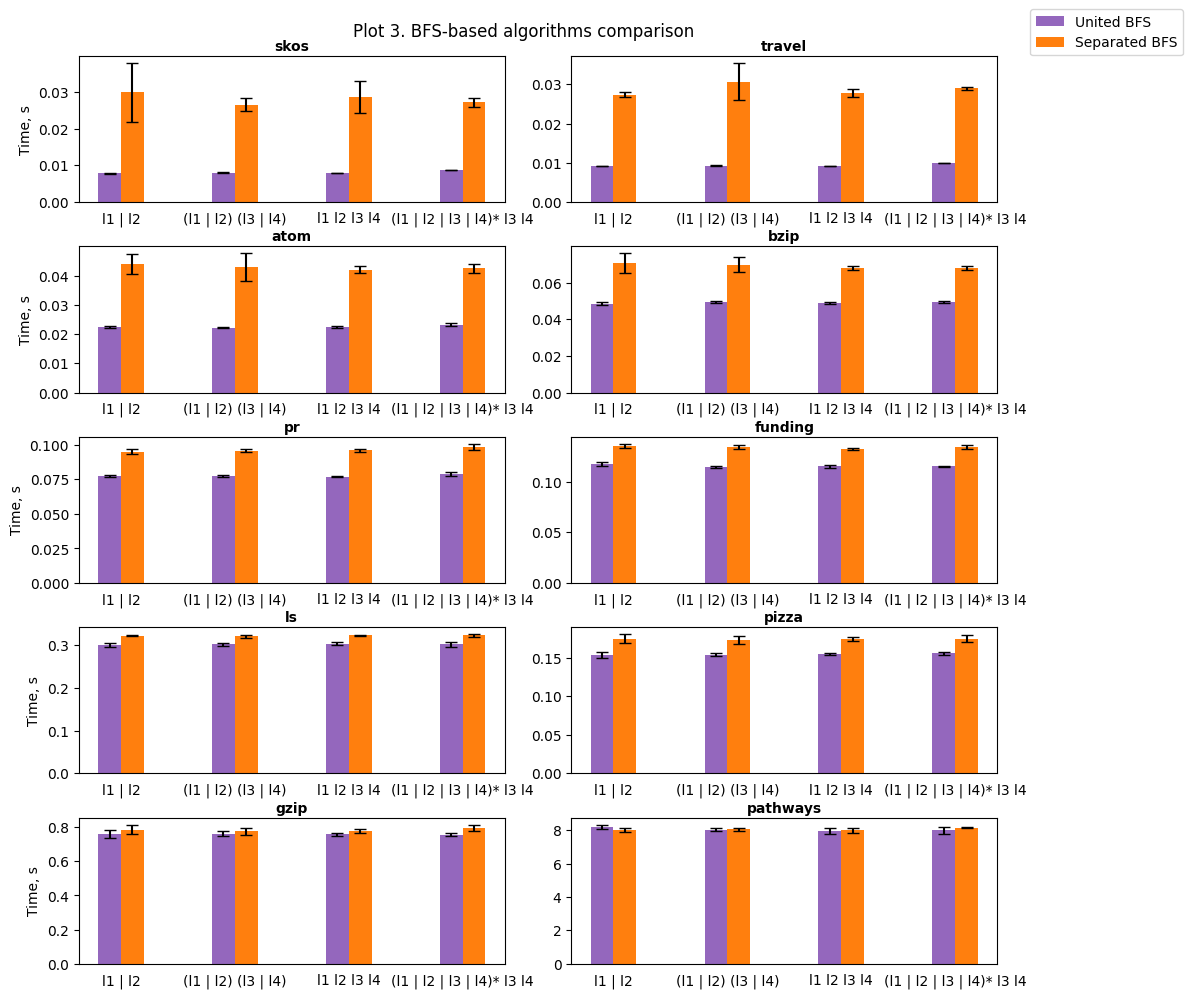

In [187]:
def show_plots_3(
    res: list[list[tuple[tuple[tuple[float, float], tuple[float, float], tuple[float, float]], tuple[
        tuple[float, float], tuple[float, float], tuple[float, float]]]]]
):
    fig_size = (2.5 * len(REGEXES), len(GRAPHS))
    label_locations = np.arange(len(REGEXES))
    bar_width = 0.2
    cap_size = 4

    fig: plt.Figure
    fig, axs = plt.subplots(len(GRAPHS) // 2, 2, figsize=fig_size)

    fig.suptitle("Plot 3. BFS-based algorithms comparison")
    fig.tight_layout()

    ax: plt.Axes
    for g_i, ax in enumerate(axs.flat):
        graph_name = GRAPHS[g_i].name
        graph_results = res[g_i]

        ax.set_xlabel(graph_name, weight="bold")
        ax.xaxis.set_label_position("top")

        ax.set_xticks(label_locations, REGEXES.keys())
        ax.tick_params(axis='x', which='both', bottom=False)
        if g_i % len(axs[0]) == 0:
            ax.set_ylabel("Time, s")

        pycubool_algo2_means = [rs[1][1][0] for rs in graph_results]
        pycubool_algo2_stdevs = [rs[1][1][1] for rs in graph_results]
        ax.bar(
            label_locations - bar_width / 2,
            pycubool_algo2_means,
            bar_width,
            yerr=pycubool_algo2_stdevs,
            color="tab:purple",
            label=ALGO_NAMES[1],
            capsize=cap_size,
        )

        pycubool_algo3_means = [rs[1][2][0] for rs in graph_results]
        pycubool_algo3_stdevs = [rs[1][2][1] for rs in graph_results]
        ax.bar(
            label_locations + bar_width / 2,
            pycubool_algo3_means,
            bar_width,
            yerr=pycubool_algo3_stdevs,
            color="tab:orange",
            label=ALGO_NAMES[2],
            capsize=cap_size,
        )

    handles, labels = axs[-1][-1].get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(1, 1), loc="upper left")

    plt.show()


show_plots_3(fixed_starts_res)

## Заключение

Таким образом, исходя из полученных результатов, для графов с числом вершин до 6000 и числом рёбер до 12000 можно сформировать следующие ответы на поставленные вопросы относительно задачи достижимости в графе с регулярными ограничениями и её решений, основанных на линейной алгебре:

1. Для решений первой и второй постановок задачи (достижимость между всеми парами вершин и достижимость для всего множества стартовых вершин) реализации, использующие ядра CUDA через библиотеку `pycubool`, показывают себя лучше реализаций на `scipy.sparse`, CUDA не использующих. Однако, при увеличении размеров графа выигрыш от применения CUDA снижается. В целом, то же является верным и для решения третьей постановки задачи (достижимость для каждой стартовой вершины отдельно), но колебания во времени работы данных решений не позволяют с полной уверенностью назвать наилучшую из реализаций для графов, где и число вершин, и число рёбер не превосходит 500.
2. При использовании `pycubool`, для любых размерах множества стартовых вершин выгоднее решать задачу достижимости между всеми парами вершин через тензорное произведение и выбирать нужные, чем сразу искать пути лишь из стартовых вершин через раздельный BFS. Но стоит отметить, что при росте размера графа для малого размера стартового множества разница во времени исполнения между алгоритмами снижается.
3. При использовании `pycubool`, нахождение достижимых вершин для всего стартового множества сразу быстрее нахождения достижимых вершин для каждой стартовой вершины отдельно на десятые доли секунды, что нивелируется погрешностью с ростом размера графа.